In [3]:
import pandas as pd
import numpy as np

In [7]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

In [11]:
# Configurar el controlador de Chrome
driver = webdriver.Chrome()

# Abrir la página web
driver.get("https://systems.inei.gob.pe/SIRTOD/app/consulta")

# Esperar a que la página cargue completamente
wait = WebDriverWait(driver, 25)

# Paso 1: Esperar a que el loader desaparezca
wait.until(EC.invisibility_of_element_located((By.ID, "loader")))

# Paso 2: Hacer clic en el campo "Buscar indicador"
search_field = wait.until(EC.visibility_of_element_located((By.XPATH, '//*[@id="indicador-cajatexto"]')))
ActionChains(driver).move_to_element(search_field).perform()
search_field.click()

# Paso 3: Escribir "anemia" en el campo de búsqueda
search_field.send_keys("anemia")
search_field.send_keys(Keys.RETURN)

# Paso 4: Hacer clic en los checkboxes correspondientes
checkboxes = [
    '//*[@id="nodoh17779"]/img',
    '//*[@id="nodoh17780"]/img',
    '//*[@id="nodoh17781"]/img',
    '//*[@id="nodoh17782"]/img'
]

for checkbox_xpath in checkboxes:
    checkbox = wait.until(EC.element_to_be_clickable((By.XPATH, checkbox_xpath)))
    checkbox.click()

# Paso 5: Hacer clic en el botón de "Ejecutar"
ejecutar_button = wait.until(EC.element_to_be_clickable((By.XPATH, '//*[@id="ubigeo-ejecutar"]/button')))
ejecutar_button.click()

# Paso 6: Extraer la tabla que aparece después de aplicar los filtros
table = wait.until(EC.presence_of_element_located((By.CLASS_NAME, "pvtTable")))
rows = table.find_elements(By.TAG_NAME, "tr")

# Crear una lista para almacenar los datos
data = [[cell.text for cell in row.find_elements(By.TAG_NAME, "td")] for row in rows if row.find_elements(By.TAG_NAME, "td")]

# Convertir los datos en un DataFrame de pandas y eliminar la última columna vacía
df = pd.DataFrame(data).iloc[:, :-1]

# Definir los encabezados manualmente (para las 18 columnas restantes)
headers = [2000, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]

# Verificar que el número de columnas coincida con los encabezados
if df.shape[1] == len(headers):
    df.columns = headers
else:
    print("El número de columnas en el DataFrame no coincide con la cantidad de encabezados proporcionados.")

# Agregar las dos nuevas columnas al lado izquierdo
df.insert(0, 'Departamento', '')
df.insert(1, 'Indicador Anemia %', '')

# Lista de departamentos
departamentos = [
    "AMAZONAS", "ÁNCASH", "APURÍMAC", "AREQUIPA", "AYACUCHO", "CAJAMARCA", 
    "CALLAO", "CUSCO", "HUANCAVELICA", "HUÁNUCO", "ICA", "JUNÍN", 
    "LA LIBERTAD", "LAMBAYEQUE", "LIMA", "LORETO", "MADRE DE DIOS", "MOQUEGUA", 
    "PASCO", "PIURA", "PUNO", "SAN MARTÍN", "TACNA", "TUMBES", 
    "UCAYALI", "LIMA METROPOLITANA 1/", "LIMA 2/"
]

# Asignar nombres de departamentos
row_idx = 0
for departamento in departamentos:
    if departamento == "LIMA METROPOLITANA 1/":
        # Excepción para "LIMA METROPOLITANA 1/"
        df.loc[row_idx:row_idx+2, 'Departamento'] = departamento
        row_idx += 3
    else:
        df.loc[row_idx:row_idx+3, 'Departamento'] = departamento
        row_idx += 4

# Llenar la columna 'Indicador Anemia %' con el patrón, omitiendo "Severa" para Lima Metropolitana
indicadores = ["Leve", "Moderada", "Severa", "Total"]
indicator_idx = 0

for idx in range(df.shape[0]):
    if df.at[idx, 'Departamento'] == "LIMA METROPOLITANA 1/" and indicator_idx == 2:
        # Saltar "Severa" para Lima Metropolitana
        indicator_idx += 1
    df.at[idx, 'Indicador Anemia %'] = indicadores[indicator_idx]
    indicator_idx = (indicator_idx + 1) % 4  # Reiniciar el patrón cada 4 indicadores

# Eliminar filas adicionales innecesarias
df.drop(index=df.index[[107, 108]], inplace=True)

# Reemplazar los NaN con el promedio de los valores numéricos en la misma fila
for col in df.columns[2:]:  
    df[col] = df[col].astype(str).replace('-', np.nan).str.replace(',', '.')
    df[col] = pd.to_numeric(df[col], errors='coerce') 

df.iloc[:, 2:] = df.iloc[:, 2:].apply(
    lambda row: row.fillna(row.mean()), axis=1
)

# (Opcional) Volver a formatear los números con comas como separador decimal
for col in df.columns[2:]:
    df[col] = df[col].apply(lambda x: f"{x:.1f}".replace('.', ','))

# Lista de las columnas de los años (como está en tu código)
year_columns = [2000, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]

# Convertir los valores a float correctamente, reemplazando comas por puntos
for year in year_columns:
    df[year] = df[year].str.replace(',', '.').astype(float)

# Iterar sobre los departamentos
for depto in df['Departamento'].unique():
    # Filtrar las filas correspondientes a 'Leve', 'Moderada', 'Severa' para este departamento
    rows_to_sum = df[(df['Departamento'] == depto) & (df['Indicador Anemia %'].isin(['Leve', 'Moderada', 'Severa']))]

    # Filtrar la fila correspondiente a 'Total' para este departamento
    total_row_idx = df[(df['Departamento'] == depto) & (df['Indicador Anemia %'] == 'Total')].index

    if not rows_to_sum.empty and not total_row_idx.empty:
        # Iterar sobre las columnas de los años
        for year in year_columns:
            # Sumar los valores de los indicadores 'Leve', 'Moderada', 'Severa' para el año en cuestión
            total_value = rows_to_sum[year].sum(skipna=True)
            
            # Asignar la suma total al año correspondiente en la fila 'Total'
            df.at[total_row_idx[0], year] = total_value

# Ver el DataFrame resultante con los totales actualizados
print(df)
# Cerrar el navegador

              Departamento Indicador Anemia %  2000  2008  2009  2010  2011  \
0                 AMAZONAS               Leve  21.9  23.0  25.3  24.7  21.4   
1                 AMAZONAS           Moderada  20.0  13.7  12.4  14.6   8.2   
2                 AMAZONAS             Severa   0.5   0.4   1.0   1.0   0.5   
3                 AMAZONAS              Total  42.4  37.1  38.7  40.3  30.1   
4                   ÁNCASH               Leve  21.0  22.8  24.4  24.2  17.3   
..                     ...                ...   ...   ...   ...   ...   ...   
102  LIMA METROPOLITANA 1/              Total  24.2  24.2  24.2  24.2  24.2   
103                LIMA 2/               Leve  21.2  21.2  21.2  21.2  21.2   
104                LIMA 2/           Moderada   7.8   7.8   7.8   7.8   7.8   
105                LIMA 2/             Severa   0.2   0.2   0.2   0.2   0.2   
106                LIMA 2/              Total  29.2  29.2  29.2  29.2  29.2   

     2012  2013  2014  2015  2016  2017  2018  2019

## **Proporción de Anemia por Nivel y Departamento en el Año Seleccionado**

In [15]:
# Lista de años disponibles
def listar_opciones(df):
    # Extraer los años como columnas numéricas
    años_disponibles = [col for col in df.columns if isinstance(col, int)]
    
    # Extraer los departamentos únicos
    departamentos_disponibles = df['Departamento'].unique()
    
    print("Años disponibles para el análisis:")
    print(años_disponibles)
    print("\nDepartamentos disponibles para el análisis:")
    print(departamentos_disponibles)

# Ejecutar la función
listar_opciones(df)

Años disponibles para el análisis:
[2000, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]

Departamentos disponibles para el análisis:
['AMAZONAS' 'ÁNCASH' 'APURÍMAC' 'AREQUIPA' 'AYACUCHO' 'CAJAMARCA' 'CALLAO'
 'CUSCO' 'HUANCAVELICA' 'HUÁNUCO' 'ICA' 'JUNÍN' 'LA LIBERTAD' 'LAMBAYEQUE'
 'LIMA' 'LORETO' 'MADRE DE DIOS' 'MOQUEGUA' 'PASCO' 'PIURA' 'PUNO'
 'SAN MARTÍN' 'TACNA' 'TUMBES' 'UCAYALI' 'LIMA METROPOLITANA 1/' 'LIMA 2/']


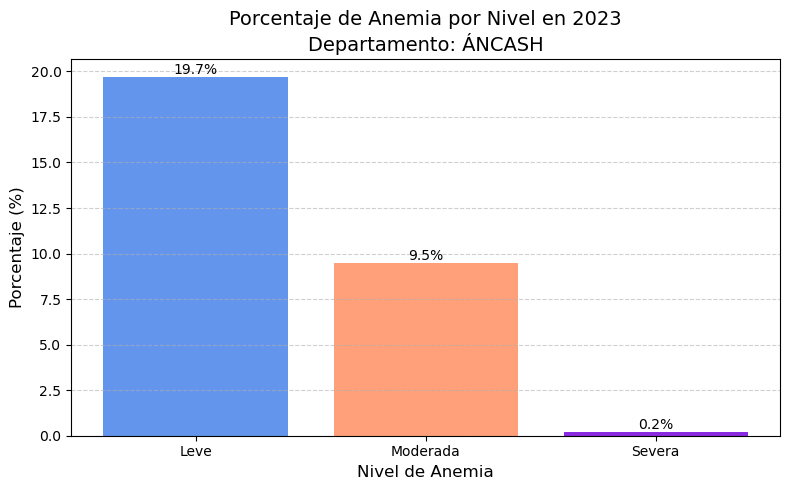

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Función para generar el gráfico
def generar_grafico(anio, departamento):
    # Filtrar datos por año y departamento
    df_anio = df[['Departamento', 'Indicador Anemia %', anio]]
    df_filtrado = df_anio[df_anio['Departamento'].str.upper() == departamento.upper()]
    
    # Excluir la categoría 'Total'
    df_filtrado = df_filtrado[df_filtrado['Indicador Anemia %'] != 'Total']
    
    # Renombrar las columnas para claridad
    df_filtrado.columns = ['Departamento', 'Indicador', 'Proporción']
    
    # Crear el gráfico
    plt.figure(figsize=(8, 5))
    bars = plt.bar(df_filtrado['Indicador'], df_filtrado['Proporción'], color=['#6495ED', '#FFA07A', '#8A2BE2'])
    
    # Agregar etiquetas encima de las barras
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{bar.get_height():.1f}%", 
                 ha='center', va='bottom', fontsize=10)
    
    # Personalizar el gráfico
    plt.title(f'Porcentaje de Anemia por Nivel en {anio}\nDepartamento: {departamento}', fontsize=14)
    plt.xlabel('Nivel de Anemia', fontsize=12)
    plt.ylabel('Porcentaje (%)', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    
    # Mostrar el gráfico
    plt.show()

# Ejemplo de uso
anio = 2023  # Cambia al año deseado
departamento = 'ÁNCASH'  # Cambia al departamento deseado
generar_grafico(anio, departamento)

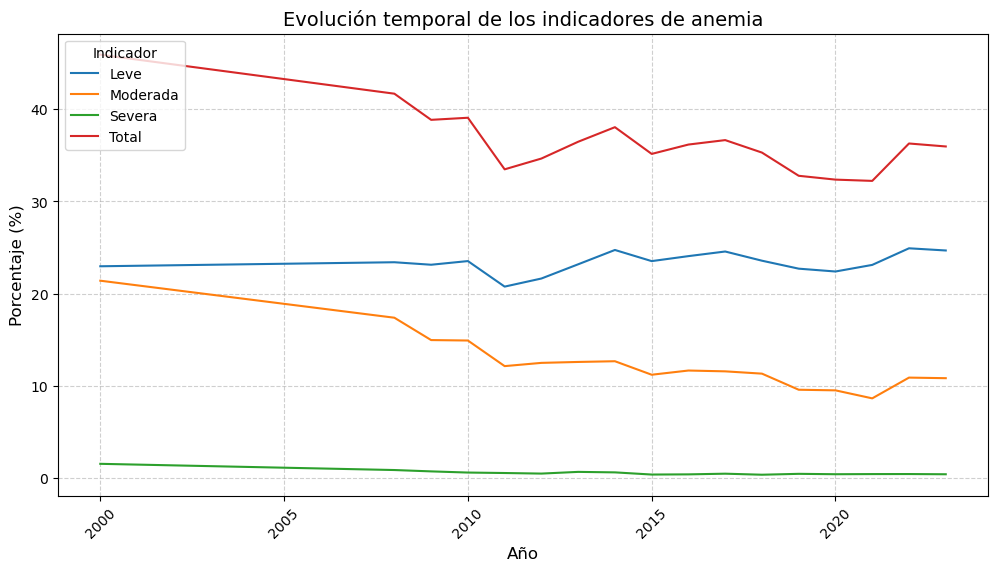


Interpretación:
1. La anemia leve muestra una tendencia ligeramente ascendente, pasando del 20% al 23% en los últimos años.
2. La anemia moderada tiene una disminución significativa, reduciéndose de un 18% a un 9% aproximadamente.
3. La anemia severa permanece estable en niveles muy bajos, oscilando entre el 2% y el 1.2%.
4. El porcentaje total de anemia muestra una tendencia descendente moderada, pasando del 40% a 33%, con algunos altibajos recientes.

Conclusión:
La disminución de la anemia moderada es un punto positivo, mientras que la anemia leve parece mantenerse como un desafío constante. Es crucial seguir trabajando en estrategias de prevención y tratamiento para reducir el impacto total de la anemia.



In [19]:
import matplotlib.pyplot as plt

# Filtrar datos relevantes (sin columnas categóricas para el análisis numérico)
numeric_data = df.iloc[:, 2:]

# Calcular estimadores estadísticos
descriptive_stats = numeric_data.describe().T  # Transponer para claridad
descriptive_stats["Range"] = descriptive_stats["max"] - descriptive_stats["min"]
descriptive_stats

# Gráficos: Evolución temporal de los indicadores de anemia
plt.figure(figsize=(12, 6))
for indicator in df["Indicador Anemia %"].unique():
    subset = df[df["Indicador Anemia %"] == indicator]
    mean_values = subset.iloc[:, 2:].mean()
    plt.plot(mean_values.index, mean_values.values, label=indicator)

# Personalización del gráfico
plt.title("Evolución temporal de los indicadores de anemia", fontsize=14)
plt.xlabel("Año", fontsize=12)
plt.ylabel("Porcentaje (%)", fontsize=12)
plt.legend(title="Indicador", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(rotation=45)
plt.show()

# Interpretación
interpretacion = """
Interpretación:
1. La anemia leve muestra una tendencia ligeramente ascendente, pasando del 20% al 23% en los últimos años.
2. La anemia moderada tiene una disminución significativa, reduciéndose de un 18% a un 9% aproximadamente.
3. La anemia severa permanece estable en niveles muy bajos, oscilando entre el 2% y el 1.2%.
4. El porcentaje total de anemia muestra una tendencia descendente moderada, pasando del 40% a 33%, con algunos altibajos recientes.

Conclusión:
La disminución de la anemia moderada es un punto positivo, mientras que la anemia leve parece mantenerse como un desafío constante. Es crucial seguir trabajando en estrategias de prevención y tratamiento para reducir el impacto total de la anemia.
"""

print(interpretacion)

# Tendencia segun el Departamento e Indicar

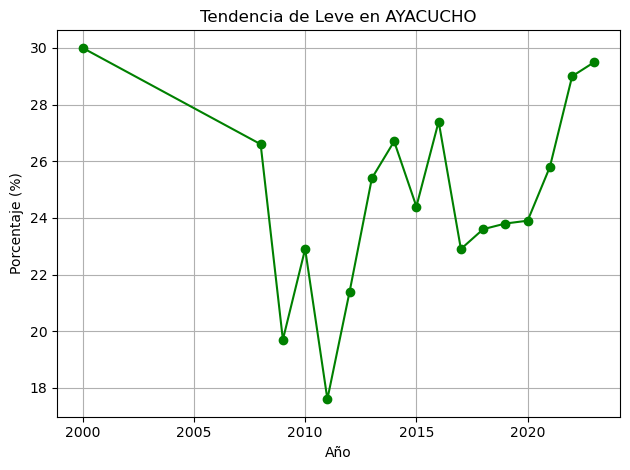

Análisis del indicador 'Leve' en AMAZONAS:
- Año con el valor más bajo: 2020 (18.0%)
- Año con el valor más alto: 2014 (33.7%)
- Tendencia general: disminución a lo largo de los años.



In [21]:

def grafico_estadistico(departamento, indicador):
    """
    Genera un gráfico estadístico (líneas) para un indicador en un departamento específico a lo largo de los años.

    Args:
        departamento (str): Nombre del departamento.
        indicador (str): Indicador de anemia (e.g., 'Leve', 'Moderada', 'Severa', 'Total').

    Returns:
        fig (matplotlib.figure.Figure): Objeto de la figura generada.
    """
    # Filtrar los datos por el departamento y el indicador
    departamento_data = df[(df['Departamento'] == departamento) &
                             (df['Indicador Anemia %'] == indicador)]

    if departamento_data.empty:
        raise ValueError(f"No se encontraron datos para el departamento '{departamento}' y el indicador '{indicador}'.")

    # Extraer los años y los valores
    anios = [col for col in df.columns if isinstance(col, int)]
    valores = departamento_data[anios].values.flatten()

    # Crear el gráfico
    fig, ax = plt.subplots()
    ax.plot(anios, valores, marker='o', linestyle='-', color='green')
    ax.set_title(f'Tendencia de {indicador} en {departamento}')
    ax.set_xlabel('Año')
    ax.set_ylabel('Porcentaje (%)')
    ax.grid(True)
    plt.tight_layout()

    return fig

def interpretar_grafico(departamento, indicador):
    """
    Interpreta los datos para el gráfico basado en el departamento y el indicador seleccionados.
    
    Args:
        departamento (str): Nombre del departamento.
        indicador (str): Indicador de anemia (e.g., 'Leve', 'Moderada', 'Severa', 'Total').
        
    Returns:
        str: Resumen interpretativo de los datos.
    """
    # Filtrar los datos
    departamento_data = df[(df['Departamento'] == departamento) &
                             (df['Indicador Anemia %'] == indicador)]
    
    if departamento_data.empty:
        return f"No se encontraron datos para el departamento '{departamento}' y el indicador '{indicador}'."
    
    # Extraer años y valores
    anios = [col for col in df.columns if isinstance(col, int)]
    valores = departamento_data[anios].values.flatten()
    
    # Calcular estadísticas clave
    valor_min = valores.min()
    anio_min = anios[valores.argmin()]
    valor_max = valores.max()
    anio_max = anios[valores.argmax()]
    tendencia = "aumento" if valores[-1] > valores[0] else "disminución"
    
    # Crear un resumen
    resumen = (
        f"Análisis del indicador '{indicador}' en {departamento}:\n"
        f"- Año con el valor más bajo: {anio_min} ({valor_min}%)\n"
        f"- Año con el valor más alto: {anio_max} ({valor_max}%)\n"
        f"- Tendencia general: {tendencia} a lo largo de los años.\n"
    )
    
    return resumen




# Crear un gráfico de ejemplo para "AMAZONAS" y el indicador "Total"
example_stat_fig = grafico_estadistico('AYACUCHO', 'Leve')
plt.show()

# Generar interpretación para "AMAZONAS" y "Total"
interpretacion = interpretar_grafico('AMAZONAS', 'Leve')
print(interpretacion)

# Departamentos con alta prevalencia en 2023 son consistentemente los más afectados en casos de Anemia

### Comparación en el año 2023 de los 5 departamentos con mayor proporción de Anemia

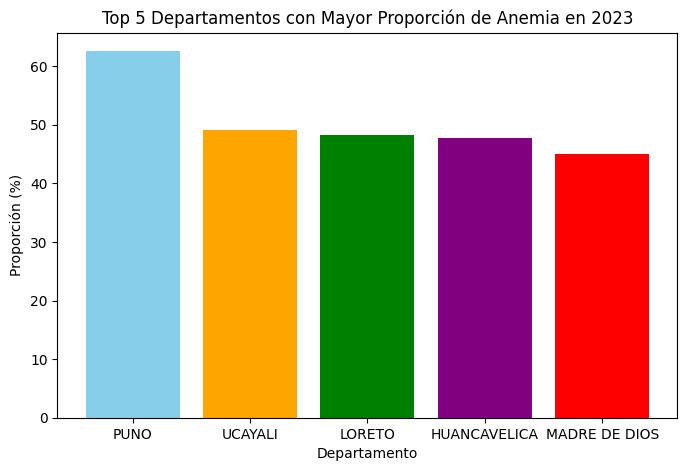

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Comparación en el año 2023 mostrando solo los 5 departamentos con mayor proporción
top_5_2023 = df_total.nlargest(5, 2023)
plt.figure(figsize=(8, 5))
plt.bar(top_5_2023['Departamento'], top_5_2023[2023], color=['skyblue', 'orange', 'green', 'purple', 'red'])
plt.title('Top 5 Departamentos con Mayor Proporción de Anemia en 2023')
plt.xlabel('Departamento')
plt.ylabel('Proporción (%)')
plt.show()

##### Interpretación:
- Puno tiene la proporción más alta de anemia total en 2023, alcanzando un valor de aproximadamente 60%. Esto lo posiciona
  como el departamento más afectado por la anemia en ese año.
- Los otros 4 departamentos (Ucayali, Loreto, Huancavelica y Madre de Dios) presentan proporciones relativamente similares,
  alrededor del rango de 40-50%. Esto podría indicar un comportamiento más homogéneo entre estos departamentos, en contraste con el valor
  significativamente alto en Puno.